# Generating spatial weights

`momepy` is using `libpysal` to handle spatial weights, but also builds on top of it. This notebook will show how to use different weights.

In [1]:
import momepy
import geopandas as gpd
import matplotlib.pyplot as plt

c:\Users\rtx3090\anaconda3\envs\momepy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation layer. 

In [2]:
import osmnx as ox

gdf = ox.geometries.geometries_from_place('Kahla, Germany', tags={'building':True})
buildings = ox.projection.project_gdf(gdf)

buildings['uID'] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(buildings, unique_id='uID', limit=limit).tessellation

C:\Users\rtx3090\AppData\Local\Temp\ipykernel_15716\1510469109.py:3: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  gdf = ox.geometries.geometries_from_place('Kahla, Germany', tags={'building':True})


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


## Queen contiguity

Morphological tessellation allows using contiguity-based weights matrix. While `libpysal.weights.contiguity.Queen` will do the standard Queen contiguity matrix of the first order; it might not be enough to capture proper context. For that reason, we can use `momepy.sw_high` to capture all neighbours within set topological distance `k`. It generates spatial weights of higher orders under the hood and joins them together.

In [4]:
sw3 = momepy.sw_high(k=3, gdf=tessellation, ids='uID')

Queen contiguity of morphological tessellation can capture the comparable level of information across the study area - the number of the neighbour is relatively similar and depends on the morphology of urban form. We can visualize it by counting the number of neighbours (as captured by `sw3`).

In [5]:
tessellation['neighbours'] = momepy.Neighbors(tessellation, sw3,'uID').series

100%|██████████| 3014/3014 [00:00<00:00, 858689.87it/s]


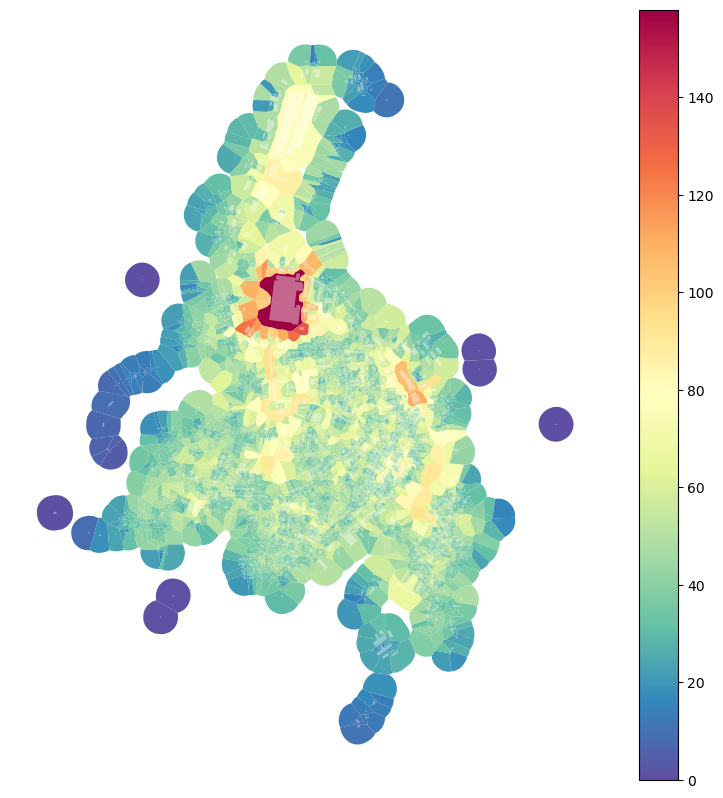

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='neighbours', legend=True, cmap='Spectral_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

## Distance

Often we want to define the neighbours based on metric distance. We will look at two options - distance band and k-nearest neighbour.

### Distance band

We can imagine distance band as a buffer of a set radius around centroid of each object, for example, 400 meters. For that, we can use `libpysal.weights.DistanceBand`:

In [6]:
import libpysal
dist400 = libpysal.weights.DistanceBand.from_dataframe(buildings, 400,
                                                       ids='uID')

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 330.
  warnings.warn(message)


Because we have defined spatial weights using uID, we can use `dist400` generated on buildings and use it on tessellation:

In [7]:
tessellation['neighbours400'] = momepy.Neighbors(tessellation, dist400, 'uID').series

  0%|          | 0/2947 [00:00<?, ?it/s]

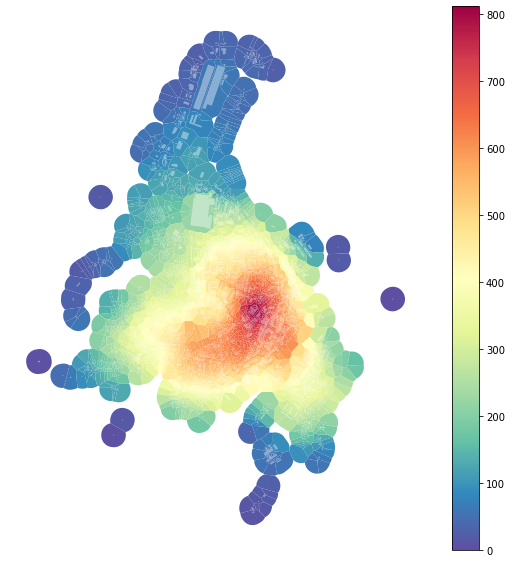

In [8]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='neighbours400', legend=True, cmap='Spectral_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

### K nearest neighbor

If we want fixed number of neighbours, we can use `libpysal.weights.KNN`:

In [9]:
knn = libpysal.weights.KNN.from_dataframe(buildings, k=200, ids='uID')
tessellation['neighboursKNN'] = momepy.Neighbors(tessellation, knn,'uID').series

  0%|          | 0/2947 [00:00<?, ?it/s]

**Note**: As all tessellation cells have the same number of neighbours (due to KNN), they all have the same colour.

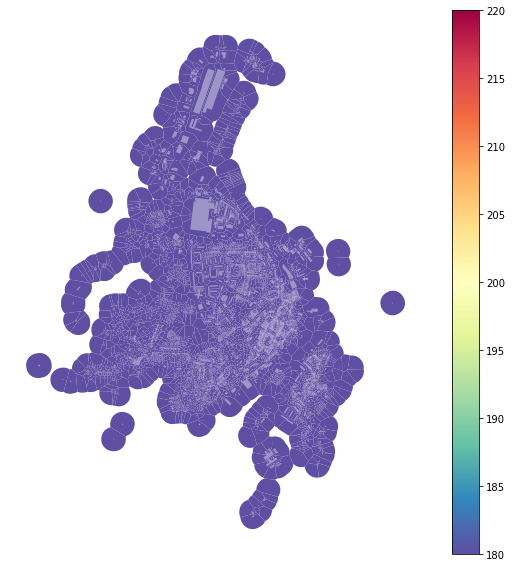

In [10]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column='neighboursKNN', legend=True, cmap='Spectral_r')
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

All of them can be used within morphometric analysis. Theoretical and practical differences are discussed in Fleischmann, Romice and Porta (2019).

For the other options on generating spatial weights see [lipysal API](https://pysal.org/libpysal/api.html).